In [1]:
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout, InputLayer, BatchNormalization

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

In [2]:
batch_size = 1000
latent_bi = 8
latent_nor = 64 - latent_bi
latent_dim = latent_nor + latent_bi

hist_dir = "hist/"
# matplotlib.use('Agg')


In [3]:
# generate training data
train_csv = os.listdir("train")
train = []
for filename in train_csv:
    if "input" in filename:
        f = filename.split(".")
        train.append(f[0][11:])

folder = "train/"
time = []

X_columns = ["power.x", "rotationalSpeed.x", "Epower1.x", "Epower2.x", "Epower3.x", "Epower4.x", 
             "steamconinput.x", "ERTemp.x", "SeaWaterTemp.x", "SWPP_rpm1.x", "SWPP_rpm2.x"]

X_all = None
for num in train:
    if num in ["14", "15", "16", "17", "18"]:
        continue
    df_X = pd.read_csv(folder+"train_input"+num+".csv")
    try:
        X_all = np.concatenate((X_all, df_X.loc[:, X_columns].to_numpy()), axis=0)
    except:
        X_all = df_X.loc[:, X_columns].to_numpy()

# normalization
X_train = np.array(X_all).astype("float32")
X_scaler = StandardScaler()
X_scaler.fit(X_all)
X_train = X_scaler.transform(X_train)


In [4]:
X_scaler.mean_

array([1.02052112e+07, 4.03298567e+01, 1.59766435e+05, 1.00579569e+05,
       5.91899353e+05, 4.95410552e+05, 6.89911129e+05, 3.12458919e+02,
       3.00081386e+02, 1.31499395e+02, 3.07555113e+02])

In [5]:
np.random.seed(0)
tf.random.set_seed(0)

min_power = np.min(X_train[:, 0])
all_powers = X_train[X_train[:, 0] != min_power][:, 0]
all_features = X_train[X_train[:, 0] != min_power][:, 1:]

batch_per_epoch = int(all_features.shape[0] // batch_size) + 1

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_features, all_powers))
dataset = dataset.shuffle(buffer_size=batch_size).batch(batch_size)


print(f"Shape of training features: {all_features.shape}")
print(f"Shape of training power.x (label): {all_powers.shape}")

"""
## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the class labels. We will have to add the number of classes to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).
"""

generator_in_channels = latent_dim + 1
discriminator_in_channels = 1 + all_features.shape[1]
print(generator_in_channels, discriminator_in_channels)


# Create the discriminator.
discriminator = Sequential(
    [
        InputLayer((discriminator_in_channels, )),
        Dense(1024, activation = 'relu'),
        Dense(1024, activation = 'relu'),
        Dense(1, activation = 'sigmoid'),
    ],
    name="discriminator",
)

# Create the generator.
generator = Sequential(
    [
        InputLayer((generator_in_channels,)),
        Dense(128, activation = 'relu'),
        Dense(512, activation = 'relu'),
        Dense(1024, activation = 'relu'),
        Dense(1024, activation = 'relu'),
        Dense(512, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(discriminator_in_channels - 1)
    ],
    name="generator",
)

# discriminator = Sequential(
#     [
#         InputLayer((discriminator_in_channels, )),
#         Dense(512, activation = 'relu'),
#         Dense(1024, activation = 'relu'),
#         Dense(512, activation = 'relu'),
#         Dense(1, activation = 'sigmoid'),
#     ],
#     name="discriminator",
# )

# # Create the generator.
# generator = Sequential(
#     [
#         InputLayer((generator_in_channels,)),
#         Dense(256, activation = 'relu'),
#         Dense(512, activation = 'relu'),
#         Dense(1024, activation = 'relu'),
#         Dense(1024, activation = 'relu'),
#         Dense(512, activation = 'relu'),
#         Dense(256, activation = 'relu'),
#         Dense(discriminator_in_channels - 1)
#     ],
#     name="generator",
# )

print(discriminator.summary())
print(generator.summary())


Shape of training features: (23912, 10)
Shape of training power.x (label): (23912,)
65 11
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              12288     
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 1,062,913
Trainable params: 1,062,913
Non-trainable params: 0
_________________________________________________________________
None
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               8448  

Text(0.5, 1.0, 'normalized power value and GMM result (min value removed)')

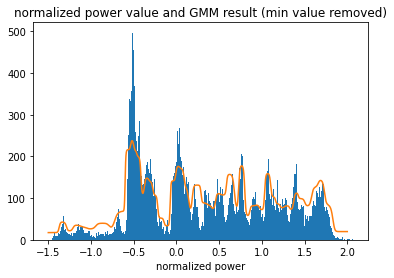

In [6]:
# fit a GMM to generate fake powers
data_gmm = all_powers.reshape([-1, 1])
gm = GaussianMixture(n_components=50, random_state=0).fit(data_gmm)
power_x = np.arange(-1.5, 2, 0.001).reshape([-1, 1])
prob = np.matmul(gm.predict_proba(power_x), gm.weights_.reshape([-1, 1]))

plt.hist(all_powers, bins=300)
plt.plot(power_x, prob * 5000)
plt.xlabel("normalized power")
plt.title("normalized power value and GMM result (min value removed)")

In [7]:
# # fit a GMM to generate fake powers
# data_gmm = all_powers[all_powers > min(all_powers)].reshape([-1, 1])
# gm = GaussianMixture(n_components=30, random_state=0).fit(data_gmm)
# power_x = np.arange(-1.5, 2, 0.001).reshape([-1, 1])
# prob = np.matmul(gm.predict_proba(power_x), gm.weights_.reshape([-1, 1]))

# plt.hist(all_powers[all_powers > min(all_powers)], bins=300)
# plt.plot(power_x, prob * 5000)
# plt.xlabel("normalized power")
# plt.title("normalized power value and GMM result (min value removed)")

In [8]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_nor, latent_bi, mean_true, cov_true, dr=1, gr=1):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_nor = latent_nor
        self.latent_bi = latent_bi
        self.latent_dim = latent_nor + latent_bi
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.cov_sqr_err_tracker = keras.metrics.Mean(name="squared_error_of_cov_mat")
        self.FID_tracker = keras.metrics.Mean(name="FID")
        self.discriminator_round = dr
        self.generator_round = gr
        self.mean_true = mean_true
        self.cov_true = cov_true

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.FID_tracker]
    
    def compile(self, d_optimizer, g_optimizer, loss_fn, **kwargs):
        super(ConditionalGAN, self).compile(**kwargs)
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def generate_latent_features(self, batch_size):
        random_latent_vectors_nor = tf.random.normal(shape=(batch_size, self.latent_nor), dtype="float32")
        random_latent_vectors_bi = tf.random.categorical(tf.math.log([[0.5, 0.5] for _ in range(batch_size)]), self.latent_bi)
        random_latent_vectors_bi = tf.cast(random_latent_vectors_bi, float)
        random_latent_vectors = tf.concat([random_latent_vectors_nor, random_latent_vectors_bi], axis=1)
        return random_latent_vectors
        
    def train_step(self, data):
        # Unpack the data.
        features, powers = data
        powers = tf.reshape(powers, [-1, 1])
        
#         self.train_count += 1
#         if self.train_count % batch_per_epoch == 0:
#             self.epoch_count += 1
#         if self.epoch_count % 10 == 0:
#             self.draw_distribution()

#         # Add dummy dimensions to the labels so that they can be concatenated with
#         # the images. This is for the discriminator.
#         image_one_hot_labels = one_hot_labels[:, :, None, None]
#         image_one_hot_labels = tf.repeat(
#             image_one_hot_labels, repeats=[image_size * image_size]
#         )
#         image_one_hot_labels = tf.reshape(
#             image_one_hot_labels, (-1, image_size, image_size, num_classes)
#         )

        
        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
#         batch_size = features.numpy().shape[0]
        batch_size = tf.shape(features)[0].numpy()
#         print("batch_size:", batch_size)
#         print("batch_size:", batch_size.numpy())
        
        for _ in range(self.discriminator_round):
#             random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), dtype="float32")
#             random_latent_vectors = tf.random.categorical(tf.math.log([[0.5, 0.5] for _ in range(batch_size)]), self.latent_dim)
#             random_latent_vectors = tf.cast(random_latent_vectors, float)
            random_latent_vectors = self.generate_latent_features(batch_size)
            fake_powers = tf.convert_to_tensor(gm.sample(batch_size)[0], dtype="float32")
            random_vector_labels = tf.concat(
                [random_latent_vectors, fake_powers], axis=1
            )
            
            # Decode the noise (guided by labels) to fake images.
            generated_features = self.generator(random_vector_labels)

            # Combine them with real images. Note that we are concatenating the labels
            # with these images here.
            fake_powers_and_features = tf.concat([fake_powers, generated_features], -1)
            real_powers_and_features = tf.concat([powers, features], -1)
            combined_data = tf.concat(
                [fake_powers_and_features, real_powers_and_features], axis=0
            )

            # Assemble labels discriminating real from fake images.
            labels = tf.concat(
                [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
            )

            # Train the discriminator.
            with tf.GradientTape() as tape:
                predictions = self.discriminator(combined_data)
                d_loss = self.loss_fn(labels, predictions)
#                 print(predictions.shape, labels.shape)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )

            
        for _ in range(self.generator_round):
            batch_size_g = batch_size * 2 
#             random_latent_vectors = tf.random.normal(shape=(batch_size_g, self.latent_dim), dtype="float32")
#             random_latent_vectors = tf.random.categorical(tf.math.log([[0.5, 0.5] for _ in range(batch_size_g)]), self.latent_dim)
#             random_latent_vectors = tf.cast(random_latent_vectors, float)
            random_latent_vectors = self.generate_latent_features(batch_size_g)
            fake_powers = tf.convert_to_tensor(gm.sample(batch_size_g)[0], dtype="float32")
            random_vector_labels = tf.concat(
                [random_latent_vectors, fake_powers], axis=1
            )
            
            # Assemble labels that say "all real images".
            misleading_labels = tf.zeros((batch_size_g, 1))

            # Train the generator (note that we should *not* update the weights of the discriminator)!
            with tf.GradientTape() as tape:
                generated_features = self.generator(random_vector_labels)
                fake_powers_and_features = tf.concat([fake_powers, generated_features], -1)
                
                predictions = self.discriminator(fake_powers_and_features)
                g_loss = self.loss_fn(misleading_labels, predictions)
#                 print(predictions.shape, misleading_labels.shape)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(
                zip(grads, self.generator.trainable_weights)
            )
        
        
        generated_features = self.generator(random_vector_labels)
        fake_data = tf.concat(
            [fake_powers, generated_features], axis=1
        ).numpy()
        cov_fake = np.cov(fake_data.T)
        disp = self.cov_true - cov_fake
        
        mean_fake = np.mean(fake_data.T, axis=1)
        
        FID = sum((self.mean_true - mean_fake)**2) + np.trace(cov_fake + self.cov_true - 2*scipy.linalg.sqrtm(cov_fake.dot(self.cov_true)))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
#         self.cov_sqr_err_tracker.update_state(sum(sum(disp ** 2)))
        self.FID_tracker.update_state(FID)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
#             "cov_sqr_err": self.cov_sqr_err_tracker.result(),
            "FID": self.FID_tracker.result()
        }




In [9]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         # every 10 epochs, draw the histogram of the true data and fake data
#         if not (epoch % 10) == 9:
#             return
#         hist_figs = os.listdir("hist")
#         if str(epoch) + '.png' in hist_figs:
#             return

#         true_data = X_train[X_train[:, 0] != min_power]
#         num = true_data.shape[0]

#         random_latent_vectors = tf.random.normal(shape=(num, latent_dim), dtype="float32")
#         fake_powers = tf.convert_to_tensor(gm.sample(num)[0], dtype="float32")
#         random_vector_labels = tf.concat(
#             [random_latent_vectors, fake_powers], axis=1
#         )

#         generated_features = self.model.generator(random_vector_labels)
#         fake_data = tf.concat(
#             [fake_powers, generated_features], axis=1
#         ).numpy()
        
#         n_bins = 50
#         fig, axs = plt.subplots(11, 2, sharey=True, figsize=(10,55))
#         plt.close()

#         for i in range(11):
#             xmin = min(true_data[:, i].min(), fake_data[:, i].min())
#             xmax = max(true_data[:, i].max(), fake_data[:, i].max())

#             axs[i][0].hist(true_data[:, i], bins=n_bins, range=[xmin, xmax])
#             axs[i][0].set_title('True distribution of ' + X_columns[i])

#             axs[i][1].hist(fake_data[:, i], bins=n_bins, range=[xmin, xmax])
#             axs[i][1].set_title('Fake distribution of ' + X_columns[i])

#         rect = fig.patch
#         rect.set_facecolor('white')
#         fig.savefig(hist_dir + str(epoch+1) + '.png')

        
        # save the model every 100 epochs
        if (epoch % 100) == 99:
            self.model.discriminator.save("models/discriminator_" + str(epoch+1) + "/")
            self.model.generator.save("models/generator_" + str(epoch+1) + "/")


In [10]:
"""
## Training the Conditional GAN
"""
checkpoint_path = "models"
checkpoint_dir = os.path.dirname(checkpoint_path)

true_data = X_train[X_train[:, 0] != min_power]
mean_true = np.mean(true_data.T, axis=1)
cov_true = np.cov(true_data.T)

cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_nor=latent_nor, latent_bi=latent_bi, mean_true=mean_true, cov_true=cov_true, dr=1, gr=1
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    g_optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss_fn=keras.losses.BinaryCrossentropy(),
    run_eagerly=True,
)


history = cond_gan.fit(x=dataset, epochs=2500, callbacks=[MyCallback()])



Epoch 1/2500
24/24 [==============================] - 2s 56ms/step - g_loss: 0.6558 - d_loss: 0.6617 - FID: 19.6829
Epoch 2/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 0.9284 - d_loss: 0.5057 - FID: 30.7318
Epoch 3/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 0.7733 - d_loss: 0.7241 - FID: 26.7504
Epoch 4/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 0.8543 - d_loss: 0.8389 - FID: 58.2266
Epoch 5/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.4477 - d_loss: 0.5517 - FID: 20.6269
Epoch 6/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 0.7581 - d_loss: 0.6049 - FID: 10.5875
Epoch 7/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 0.7500 - d_loss: 0.5733 - FID: 14.4093
Epoch 8/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.1904 - d_loss: 0.4894 - FID: 16.0774
Epoch 9/2500
24/24 [==============================] - 1s 53ms/step - g_l

24/24 [==============================] - 1s 53ms/step - g_loss: 0.9376 - d_loss: 0.5728 - FID: 14.0625
Epoch 72/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 0.9764 - d_loss: 0.5212 - FID: 9.1026
Epoch 73/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 0.8713 - d_loss: 0.5075 - FID: 9.0787
Epoch 74/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 0.8359 - d_loss: 0.5116 - FID: 11.4276
Epoch 75/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 0.5264 - d_loss: 0.8105 - FID: 35.4585
Epoch 76/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 1.7559 - d_loss: 0.5044 - FID: 30.0456
Epoch 77/2500
24/24 [==============================] - 1s 56ms/step - g_loss: 0.9776 - d_loss: 0.6576 - FID: 12.7071
Epoch 78/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 1.0508 - d_loss: 0.6280 - FID: 13.7500
Epoch 79/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 1.

24/24 [==============================] - 1s 52ms/step - g_loss: 0.7124 - d_loss: 0.8615 - FID: 30.1629
Epoch 137/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 1.2870 - d_loss: 0.5547 - FID: 9.8235
Epoch 138/2500
24/24 [==============================] - 1s 53ms/step - g_loss: 0.9078 - d_loss: 0.5343 - FID: 8.2584
Epoch 139/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 0.8257 - d_loss: 0.5124 - FID: 8.2927
Epoch 140/2500
24/24 [==============================] - 1s 53ms/step - g_loss: 0.6317 - d_loss: 0.6550 - FID: 15.5230
Epoch 141/2500
24/24 [==============================] - 1s 53ms/step - g_loss: 2.0057 - d_loss: 0.5037 - FID: 23.5470
Epoch 142/2500
24/24 [==============================] - 1s 53ms/step - g_loss: 0.6466 - d_loss: 0.9274 - FID: 16.8059
Epoch 143/2500
24/24 [==============================] - 1s 54ms/step - g_loss: 1.2421 - d_loss: 0.5677 - FID: 19.0120
Epoch 144/2500
24/24 [==============================] - 1s 54ms/step - g_l

Epoch 201/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 0.8523 - d_loss: 0.5619 - FID: 36.9967
Epoch 202/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 0.9585 - d_loss: 0.7301 - FID: 39.9283
Epoch 203/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 0.9149 - d_loss: 1.0020 - FID: 12.7428
Epoch 204/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.0392 - d_loss: 0.9293 - FID: 12.3319
Epoch 205/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.3205 - d_loss: 0.6931 - FID: 8.6281
Epoch 206/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1004 - d_loss: 0.5878 - FID: 8.6266
Epoch 207/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.0797 - d_loss: 0.5417 - FID: 10.3038
Epoch 208/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.0528 - d_loss: 0.5525 - FID: 10.2115
Epoch 209/2500
24/24 [==============================] - 1s

24/24 [==============================] - 1s 49ms/step - g_loss: 1.4347 - d_loss: 0.4354 - FID: 11.2871
Epoch 271/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 0.9847 - d_loss: 0.5121 - FID: 9.0166
Epoch 272/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 0.7008 - d_loss: 0.6045 - FID: 11.6837
Epoch 273/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 0.7506 - d_loss: 0.5854 - FID: 11.3781
Epoch 274/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 0.8083 - d_loss: 0.5810 - FID: 21.2878
Epoch 275/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 2.8638 - d_loss: 0.6356 - FID: 31.6498
Epoch 276/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.2827 - d_loss: 0.6797 - FID: 11.2995
Epoch 277/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 0.8881 - d_loss: 0.6726 - FID: 14.3761
Epoch 278/2500
24/24 [==============================] - 1s 46ms/step - g

24/24 [==============================] - 1s 47ms/step - g_loss: 0.7998 - d_loss: 0.7146 - FID: 14.7819
Epoch 335/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1852 - d_loss: 0.5775 - FID: 9.4300
Epoch 336/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 0.9814 - d_loss: 0.5745 - FID: 8.2774
Epoch 337/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 0.7091 - d_loss: 0.6913 - FID: 12.1174
Epoch 338/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.0335 - d_loss: 0.6518 - FID: 17.1146
Epoch 339/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1812 - d_loss: 0.5580 - FID: 12.3147
Epoch 340/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 0.9396 - d_loss: 0.5467 - FID: 9.3440
Epoch 341/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 0.8449 - d_loss: 0.5432 - FID: 10.0494
Epoch 342/2500
24/24 [==============================] - 1s 47ms/step - g_l

INFO:tensorflow:Assets written to: models/generator_400/assets
24/24 [==============================] - 2s 83ms/step - g_loss: 1.0250 - d_loss: 0.5240 - FID: 8.4493
Epoch 401/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 0.8929 - d_loss: 0.7010 - FID: 16.2306
Epoch 402/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1874 - d_loss: 0.6499 - FID: 8.3293
Epoch 403/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.0567 - d_loss: 0.6173 - FID: 9.4369
Epoch 404/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1740 - d_loss: 0.5392 - FID: 11.3855
Epoch 405/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 0.9236 - d_loss: 0.6125 - FID: 9.4294
Epoch 406/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 0.7937 - d_loss: 0.6599 - FID: 10.2820
Epoch 407/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 0.8929 - d_loss: 0.6243 - FID: 10.9930
Epoch 408/25

24/24 [==============================] - 1s 52ms/step - g_loss: 0.8651 - d_loss: 0.5182 - FID: 7.0587
Epoch 470/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 0.7318 - d_loss: 0.9967 - FID: 12.8654
Epoch 471/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.0462 - d_loss: 0.7447 - FID: 9.0668
Epoch 472/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.2128 - d_loss: 0.5840 - FID: 9.0892
Epoch 473/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1792 - d_loss: 0.5092 - FID: 8.5376
Epoch 474/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1495 - d_loss: 0.4897 - FID: 8.6603
Epoch 475/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1819 - d_loss: 0.4539 - FID: 8.4416
Epoch 476/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 0.9889 - d_loss: 0.5214 - FID: 9.7113
Epoch 477/2500
24/24 [==============================] - 1s 48ms/step - g_loss:

24/24 [==============================] - 1s 51ms/step - g_loss: 0.8920 - d_loss: 0.6522 - FID: 8.2245
Epoch 535/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 0.6911 - d_loss: 0.7194 - FID: 8.6018
Epoch 536/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 1.0851 - d_loss: 0.6855 - FID: 10.0407
Epoch 537/2500
24/24 [==============================] - 1s 53ms/step - g_loss: 1.3070 - d_loss: 0.5637 - FID: 7.7742
Epoch 538/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 1.1365 - d_loss: 0.4822 - FID: 7.0610
Epoch 539/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 1.0816 - d_loss: 0.4849 - FID: 6.6826
Epoch 540/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 1.1109 - d_loss: 0.5294 - FID: 6.8810
Epoch 541/2500
24/24 [==============================] - 1s 57ms/step - g_loss: 1.1492 - d_loss: 0.5510 - FID: 6.9315
Epoch 542/2500
24/24 [==============================] - 1s 52ms/step - g_loss:

INFO:tensorflow:Assets written to: models/generator_600/assets
24/24 [==============================] - 2s 87ms/step - g_loss: 1.2153 - d_loss: 0.3985 - FID: 7.1085
Epoch 601/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 0.8513 - d_loss: 0.5908 - FID: 15.0485
Epoch 602/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.2984 - d_loss: 0.6460 - FID: 9.0579
Epoch 603/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 0.8170 - d_loss: 0.7068 - FID: 9.8536
Epoch 604/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 0.9652 - d_loss: 0.5992 - FID: 12.5907
Epoch 605/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.5412 - d_loss: 0.4046 - FID: 11.8230
Epoch 606/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.5793 - d_loss: 0.3307 - FID: 9.5656
Epoch 607/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.2121 - d_loss: 0.3593 - FID: 9.1483
Epoch 608/250

24/24 [==============================] - 1s 46ms/step - g_loss: 1.1867 - d_loss: 0.4763 - FID: 10.7025
Epoch 670/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.1738 - d_loss: 0.5324 - FID: 8.6279
Epoch 671/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.0016 - d_loss: 0.5705 - FID: 8.2395
Epoch 672/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.3532 - d_loss: 0.4578 - FID: 8.7398
Epoch 673/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2627 - d_loss: 0.4578 - FID: 7.4265
Epoch 674/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.2240 - d_loss: 0.4204 - FID: 6.9745
Epoch 675/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 1.0808 - d_loss: 0.5070 - FID: 5.8767
Epoch 676/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.0268 - d_loss: 0.5257 - FID: 5.7496
Epoch 677/2500
24/24 [==============================] - 1s 54ms/step - g_loss:

24/24 [==============================] - 1s 48ms/step - g_loss: 1.3721 - d_loss: 0.4688 - FID: 6.5927
Epoch 735/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.1266 - d_loss: 0.4767 - FID: 6.6844
Epoch 736/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.1585 - d_loss: 0.4707 - FID: 8.6438
Epoch 737/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.3745 - d_loss: 0.4037 - FID: 9.3091
Epoch 738/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.5721 - d_loss: 0.4518 - FID: 7.9034
Epoch 739/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.3251 - d_loss: 0.5090 - FID: 6.5847
Epoch 740/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.0482 - d_loss: 0.5358 - FID: 7.9293
Epoch 741/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.4710 - d_loss: 0.4903 - FID: 8.4339
Epoch 742/2500
24/24 [==============================] - 1s 53ms/step - g_loss: 

INFO:tensorflow:Assets written to: models/generator_800/assets
24/24 [==============================] - 2s 86ms/step - g_loss: 1.1214 - d_loss: 0.4967 - FID: 5.9052
Epoch 801/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.3206 - d_loss: 0.5189 - FID: 4.5095
Epoch 802/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.1903 - d_loss: 0.4954 - FID: 4.3552
Epoch 803/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.1948 - d_loss: 0.5223 - FID: 4.4022
Epoch 804/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.2768 - d_loss: 0.4736 - FID: 3.8324
Epoch 805/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.1239 - d_loss: 0.4530 - FID: 4.1124
Epoch 806/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.1420 - d_loss: 0.4423 - FID: 5.5110
Epoch 807/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.2996 - d_loss: 0.4223 - FID: 5.9467
Epoch 808/2500
2

24/24 [==============================] - 1s 50ms/step - g_loss: 2.0383 - d_loss: 0.6017 - FID: 9.0690
Epoch 870/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.5368 - d_loss: 0.4335 - FID: 8.5049
Epoch 871/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.5576 - d_loss: 0.3860 - FID: 8.2718
Epoch 872/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.6215 - d_loss: 0.3446 - FID: 8.2167
Epoch 873/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.6322 - d_loss: 0.3302 - FID: 8.3560
Epoch 874/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.7974 - d_loss: 0.3544 - FID: 10.3309
Epoch 875/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.6698 - d_loss: 0.4311 - FID: 7.4634
Epoch 876/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2627 - d_loss: 0.5649 - FID: 5.2428
Epoch 877/2500
24/24 [==============================] - 1s 47ms/step - g_loss:

24/24 [==============================] - 1s 48ms/step - g_loss: 1.2780 - d_loss: 0.3288 - FID: 7.0625
Epoch 935/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 1.3508 - d_loss: 0.3255 - FID: 8.6625
Epoch 936/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.5882 - d_loss: 0.2888 - FID: 8.7235
Epoch 937/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.5360 - d_loss: 0.2836 - FID: 8.8847
Epoch 938/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.3857 - d_loss: 0.2919 - FID: 9.1688
Epoch 939/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.4839 - d_loss: 0.2749 - FID: 9.1595
Epoch 940/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.4064 - d_loss: 0.2983 - FID: 8.1121
Epoch 941/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.6645 - d_loss: 0.3684 - FID: 6.3507
Epoch 942/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 

INFO:tensorflow:Assets written to: models/generator_1000/assets
24/24 [==============================] - 2s 81ms/step - g_loss: 1.2393 - d_loss: 0.4907 - FID: 5.9227
Epoch 1001/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.3880 - d_loss: 0.4775 - FID: 6.0465
Epoch 1002/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.3995 - d_loss: 0.4666 - FID: 5.8840
Epoch 1003/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 1.3551 - d_loss: 0.4780 - FID: 6.2225
Epoch 1004/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.6383 - d_loss: 0.4466 - FID: 6.1872
Epoch 1005/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.3876 - d_loss: 0.4733 - FID: 6.9010
Epoch 1006/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.3290 - d_loss: 0.5429 - FID: 8.8699
Epoch 1007/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.5946 - d_loss: 0.4777 - FID: 8.1955
Epoch 10

24/24 [==============================] - 1s 46ms/step - g_loss: 1.1638 - d_loss: 0.3510 - FID: 7.0880
Epoch 1070/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 0.9481 - d_loss: 0.4490 - FID: 10.3165
Epoch 1071/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.0364 - d_loss: 0.4881 - FID: 13.3861
Epoch 1072/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.1821 - d_loss: 0.4519 - FID: 14.1528
Epoch 1073/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.5456 - d_loss: 0.5172 - FID: 16.8436
Epoch 1074/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.6077 - d_loss: 0.5820 - FID: 11.9642
Epoch 1075/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 0.9203 - d_loss: 0.7294 - FID: 7.4887
Epoch 1076/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.3635 - d_loss: 0.5930 - FID: 7.1733
Epoch 1077/2500
24/24 [==============================] - 1s 51ms/st

24/24 [==============================] - 1s 52ms/step - g_loss: 1.3567 - d_loss: 0.4212 - FID: 5.0741
Epoch 1134/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.3238 - d_loss: 0.4016 - FID: 5.8852
Epoch 1135/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4324 - d_loss: 0.4009 - FID: 5.3680
Epoch 1136/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.0334 - d_loss: 0.4829 - FID: 4.7514
Epoch 1137/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.0697 - d_loss: 0.5539 - FID: 4.6298
Epoch 1138/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.0100 - d_loss: 0.6628 - FID: 5.7492
Epoch 1139/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1270 - d_loss: 0.6939 - FID: 4.7233
Epoch 1140/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.1265 - d_loss: 0.5971 - FID: 4.4854
Epoch 1141/2500
24/24 [==============================] - 1s 47ms/step - 

INFO:tensorflow:Assets written to: models/generator_1200/assets
24/24 [==============================] - 2s 83ms/step - g_loss: 1.3227 - d_loss: 0.4266 - FID: 9.2880
Epoch 1201/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.5194 - d_loss: 0.4734 - FID: 8.3281
Epoch 1202/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.3053 - d_loss: 0.5137 - FID: 8.3284
Epoch 1203/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4458 - d_loss: 0.4880 - FID: 6.8530
Epoch 1204/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.4009 - d_loss: 0.4419 - FID: 6.4450
Epoch 1205/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.5235 - d_loss: 0.4372 - FID: 7.4965
Epoch 1206/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2985 - d_loss: 0.5157 - FID: 5.7899
Epoch 1207/2500
24/24 [==============================] - 1s 52ms/step - g_loss: 1.3993 - d_loss: 0.4959 - FID: 6.9991
Epoch 12

24/24 [==============================] - 1s 47ms/step - g_loss: 1.1533 - d_loss: 0.4803 - FID: 6.3907
Epoch 1268/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2986 - d_loss: 0.3994 - FID: 7.2015
Epoch 1269/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4170 - d_loss: 0.3794 - FID: 7.6338
Epoch 1270/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.6458 - d_loss: 0.3156 - FID: 7.0556
Epoch 1271/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4704 - d_loss: 0.3011 - FID: 6.3712
Epoch 1272/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1477 - d_loss: 0.3779 - FID: 6.5952
Epoch 1273/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1498 - d_loss: 0.4662 - FID: 7.8200
Epoch 1274/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.6507 - d_loss: 0.4257 - FID: 8.5761
Epoch 1275/2500
24/24 [==============================] - 1s 48ms/step - 

24/24 [==============================] - 1s 47ms/step - g_loss: 1.4939 - d_loss: 0.3697 - FID: 7.1658
Epoch 1332/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.8431 - d_loss: 0.2974 - FID: 6.4467
Epoch 1333/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2456 - d_loss: 0.3591 - FID: 5.0107
Epoch 1334/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.3141 - d_loss: 0.3703 - FID: 5.6321
Epoch 1335/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.4362 - d_loss: 0.3636 - FID: 5.1964
Epoch 1336/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1773 - d_loss: 0.4714 - FID: 6.1438
Epoch 1337/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.3149 - d_loss: 0.4316 - FID: 6.7022
Epoch 1338/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2979 - d_loss: 0.4109 - FID: 5.5257
Epoch 1339/2500
24/24 [==============================] - 1s 48ms/step - 

23/24 [===========================>..] - ETA: 0s - g_loss: 1.4841 - d_loss: 0.6351 - FID: 6.3729WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
INFO:tensorflow:Assets written to: models/discriminator_1400/assets
INFO:tensorflow:Assets written to: models/generator_1400/assets
24/24 [==============================] - 2s 85ms/step - g_loss: 1.4695 - d_loss: 0.6308 - FID: 6.3771
Epoch 1401/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.4202 - d_loss: 0.7352 - FID: 6.6543
Epoch 1402/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.6977 - d_loss: 0.8985 - FID: 5.8760
Epoch 1403/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 0.9170 - d_loss: 0.6630 - FID: 5.9285
Epoch 1404/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2423 - d_loss: 0.4623 - FID: 6.9439
Epoch 1405/2500
24/24 [=====

24/24 [==============================] - 1s 47ms/step - g_loss: 1.2668 - d_loss: 0.3960 - FID: 5.8524
Epoch 1465/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4844 - d_loss: 0.3193 - FID: 5.4033
Epoch 1466/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2168 - d_loss: 0.3434 - FID: 5.1815
Epoch 1467/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2253 - d_loss: 0.3566 - FID: 5.9550
Epoch 1468/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.4003 - d_loss: 0.3479 - FID: 6.3476
Epoch 1469/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4467 - d_loss: 0.3035 - FID: 5.0694
Epoch 1470/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4512 - d_loss: 0.2923 - FID: 5.1359
Epoch 1471/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.3679 - d_loss: 0.2958 - FID: 5.4165
Epoch 1472/2500
24/24 [==============================] - 1s 47ms/step - 

24/24 [==============================] - 1s 46ms/step - g_loss: 1.6014 - d_loss: 0.3977 - FID: 9.2056
Epoch 1529/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.6637 - d_loss: 0.3428 - FID: 9.2892
Epoch 1530/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.6620 - d_loss: 0.3125 - FID: 8.6547
Epoch 1531/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.6302 - d_loss: 0.2974 - FID: 7.9142
Epoch 1532/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.3274 - d_loss: 0.3440 - FID: 6.7280
Epoch 1533/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.3487 - d_loss: 0.3243 - FID: 6.4574
Epoch 1534/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4011 - d_loss: 0.2930 - FID: 5.6870
Epoch 1535/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1838 - d_loss: 0.4260 - FID: 6.2259
Epoch 1536/2500
24/24 [==============================] - 1s 47ms/step - 

24/24 [==============================] - 1s 47ms/step - g_loss: 1.6358 - d_loss: 0.4036 - FID: 6.4235
Epoch 1598/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.6321 - d_loss: 0.3794 - FID: 5.3452
Epoch 1599/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4291 - d_loss: 0.3538 - FID: 5.6255
Epoch 1600/2500
24/24 [==============================] - ETA: 0s - g_loss: 1.4370 - d_loss: 0.3486 - FID: 6.0443WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
INFO:tensorflow:Assets written to: models/discriminator_1600/assets
INFO:tensorflow:Assets written to: models/generator_1600/assets
24/24 [==============================] - 2s 80ms/step - g_loss: 1.4351 - d_loss: 0.3499 - FID: 6.0443
Epoch 1601/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.5421 - d_loss: 0.3687 - FID: 7.3982
Epoch 1602/2500
24/24 [=====

24/24 [==============================] - 1s 57ms/step - g_loss: 1.2569 - d_loss: 0.4976 - FID: 3.4500
Epoch 1662/2500
24/24 [==============================] - 1s 55ms/step - g_loss: 1.3073 - d_loss: 0.4797 - FID: 3.1623
Epoch 1663/2500
24/24 [==============================] - 1s 56ms/step - g_loss: 1.2973 - d_loss: 0.4053 - FID: 3.2607
Epoch 1664/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 1.2190 - d_loss: 0.4133 - FID: 3.6789
Epoch 1665/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 1.3081 - d_loss: 0.4414 - FID: 4.1427
Epoch 1666/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.3828 - d_loss: 0.4592 - FID: 3.9833
Epoch 1667/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.3915 - d_loss: 0.4239 - FID: 3.6384
Epoch 1668/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.2116 - d_loss: 0.4657 - FID: 4.3773
Epoch 1669/2500
24/24 [==============================] - 1s 50ms/step - 

24/24 [==============================] - 1s 47ms/step - g_loss: 1.6263 - d_loss: 0.2788 - FID: 10.4289
Epoch 1726/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.7534 - d_loss: 0.2492 - FID: 10.3222
Epoch 1727/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.6316 - d_loss: 0.3082 - FID: 8.6902
Epoch 1728/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.6141 - d_loss: 0.4481 - FID: 7.6437
Epoch 1729/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.6158 - d_loss: 0.4390 - FID: 7.3120
Epoch 1730/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 1.0426 - d_loss: 0.4324 - FID: 8.5543
Epoch 1731/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.6280 - d_loss: 0.3493 - FID: 9.7132
Epoch 1732/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.7750 - d_loss: 0.2574 - FID: 8.1933
Epoch 1733/2500
24/24 [==============================] - 1s 48ms/step 

24/24 [==============================] - 1s 48ms/step - g_loss: 1.4046 - d_loss: 0.4364 - FID: 6.6243
Epoch 1795/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.7771 - d_loss: 0.4200 - FID: 6.5100
Epoch 1796/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.5997 - d_loss: 0.3895 - FID: 5.8002
Epoch 1797/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.3480 - d_loss: 0.4275 - FID: 5.3562
Epoch 1798/2500
24/24 [==============================] - 1s 53ms/step - g_loss: 1.3825 - d_loss: 0.4895 - FID: 5.8729
Epoch 1799/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.5802 - d_loss: 0.4606 - FID: 6.5532
Epoch 1800/2500
23/24 [===========================>..] - ETA: 0s - g_loss: 1.3259 - d_loss: 0.3978 - FID: 7.3472WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
INFO:tensorflow:Assets wri

24/24 [==============================] - 1s 47ms/step - g_loss: 1.5336 - d_loss: 0.4009 - FID: 5.4980
Epoch 1859/2500
24/24 [==============================] - 1s 49ms/step - g_loss: 1.5857 - d_loss: 0.3895 - FID: 5.2546
Epoch 1860/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.5348 - d_loss: 0.3768 - FID: 4.8144
Epoch 1861/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.4841 - d_loss: 0.3937 - FID: 5.1040
Epoch 1862/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.3842 - d_loss: 0.4397 - FID: 5.5625
Epoch 1863/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.3572 - d_loss: 0.5314 - FID: 7.9576
Epoch 1864/2500
24/24 [==============================] - 1s 45ms/step - g_loss: 1.6818 - d_loss: 0.4960 - FID: 7.9942
Epoch 1865/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4946 - d_loss: 0.4465 - FID: 7.1902
Epoch 1866/2500
24/24 [==============================] - 1s 46ms/step - 

24/24 [==============================] - 1s 46ms/step - g_loss: 2.0527 - d_loss: 0.4006 - FID: 7.8802
Epoch 1923/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.6885 - d_loss: 0.3255 - FID: 6.5558
Epoch 1924/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 1.5670 - d_loss: 0.3634 - FID: 5.6341
Epoch 1925/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.3004 - d_loss: 0.4309 - FID: 5.5616
Epoch 1926/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.4450 - d_loss: 0.3746 - FID: 5.5748
Epoch 1927/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.4772 - d_loss: 0.3364 - FID: 5.3044
Epoch 1928/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.4496 - d_loss: 0.3289 - FID: 5.4212
Epoch 1929/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.5393 - d_loss: 0.3085 - FID: 5.2652
Epoch 1930/2500
24/24 [==============================] - 1s 46ms/step - 

24/24 [==============================] - 1s 46ms/step - g_loss: 1.4609 - d_loss: 0.4813 - FID: 4.4096
Epoch 1992/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4002 - d_loss: 0.4112 - FID: 3.2640
Epoch 1993/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.3560 - d_loss: 0.4094 - FID: 3.1176
Epoch 1994/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.3742 - d_loss: 0.4224 - FID: 3.1195
Epoch 1995/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4414 - d_loss: 0.4157 - FID: 3.1155
Epoch 1996/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.3967 - d_loss: 0.4220 - FID: 3.5258
Epoch 1997/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2629 - d_loss: 0.5391 - FID: 4.6735
Epoch 1998/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 1.7044 - d_loss: 0.4941 - FID: 5.1636
Epoch 1999/2500
24/24 [==============================] - 1s 49ms/step - 

24/24 [==============================] - 1s 51ms/step - g_loss: 1.7465 - d_loss: 0.2706 - FID: 4.9255
Epoch 2056/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.9047 - d_loss: 0.2701 - FID: 5.0338
Epoch 2057/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.8542 - d_loss: 0.3416 - FID: 4.6309
Epoch 2058/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.9194 - d_loss: 0.3023 - FID: 3.9575
Epoch 2059/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.3884 - d_loss: 0.4304 - FID: 3.3879
Epoch 2060/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.6343 - d_loss: 0.3914 - FID: 4.5840
Epoch 2061/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.6465 - d_loss: 0.5151 - FID: 4.7257
Epoch 2062/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4914 - d_loss: 0.4408 - FID: 3.8160
Epoch 2063/2500
24/24 [==============================] - 1s 47ms/step - 

24/24 [==============================] - 1s 46ms/step - g_loss: 1.7864 - d_loss: 0.5195 - FID: 6.4769
Epoch 2120/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.4867 - d_loss: 0.7069 - FID: 7.0206
Epoch 2121/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.5862 - d_loss: 0.4540 - FID: 6.0773
Epoch 2122/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.6197 - d_loss: 0.4542 - FID: 6.7587
Epoch 2123/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.9556 - d_loss: 0.4928 - FID: 7.2514
Epoch 2124/2500
24/24 [==============================] - 1s 50ms/step - g_loss: 1.8571 - d_loss: 0.5177 - FID: 5.9462
Epoch 2125/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 1.6922 - d_loss: 0.4419 - FID: 5.0901
Epoch 2126/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.7604 - d_loss: 0.3114 - FID: 5.0414
Epoch 2127/2500
24/24 [==============================] - 1s 46ms/step - 

24/24 [==============================] - 1s 47ms/step - g_loss: 1.5089 - d_loss: 0.3987 - FID: 4.2390
Epoch 2189/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.3867 - d_loss: 0.4205 - FID: 4.1082
Epoch 2190/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.3455 - d_loss: 0.5048 - FID: 5.8610
Epoch 2191/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.9488 - d_loss: 0.5756 - FID: 11.5734
Epoch 2192/2500
24/24 [==============================] - 1s 51ms/step - g_loss: 2.1326 - d_loss: 0.5040 - FID: 7.7729
Epoch 2193/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.5415 - d_loss: 0.4472 - FID: 4.5611
Epoch 2194/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4677 - d_loss: 0.4360 - FID: 4.0757
Epoch 2195/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.4939 - d_loss: 0.5468 - FID: 4.5615
Epoch 2196/2500
24/24 [==============================] - 1s 47ms/step -

24/24 [==============================] - 1s 49ms/step - g_loss: 1.4064 - d_loss: 0.4315 - FID: 4.2157
Epoch 2253/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.4736 - d_loss: 0.4305 - FID: 4.5783
Epoch 2254/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.2722 - d_loss: 0.5294 - FID: 6.6459
Epoch 2255/2500
24/24 [==============================] - 1s 53ms/step - g_loss: 1.2457 - d_loss: 0.7466 - FID: 5.3739
Epoch 2256/2500
24/24 [==============================] - 1s 48ms/step - g_loss: 1.7186 - d_loss: 0.5868 - FID: 5.4299
Epoch 2257/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4368 - d_loss: 0.4686 - FID: 5.0876
Epoch 2258/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.4768 - d_loss: 0.4691 - FID: 5.7372
Epoch 2259/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.7563 - d_loss: 0.5042 - FID: 6.4359
Epoch 2260/2500
24/24 [==============================] - 1s 46ms/step - 

24/24 [==============================] - 1s 46ms/step - g_loss: 1.1402 - d_loss: 0.5052 - FID: 4.6162
Epoch 2317/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2815 - d_loss: 0.4818 - FID: 4.0833
Epoch 2318/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.2987 - d_loss: 0.4624 - FID: 4.0660
Epoch 2319/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.3204 - d_loss: 0.4338 - FID: 4.0514
Epoch 2320/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1734 - d_loss: 0.4555 - FID: 4.3409
Epoch 2321/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.3601 - d_loss: 0.4637 - FID: 4.6952
Epoch 2322/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2439 - d_loss: 0.4903 - FID: 3.8395
Epoch 2323/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.2220 - d_loss: 0.4742 - FID: 3.9077
Epoch 2324/2500
24/24 [==============================] - 1s 46ms/step - 

24/24 [==============================] - 1s 47ms/step - g_loss: 1.2130 - d_loss: 0.5163 - FID: 3.6546
Epoch 2386/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1932 - d_loss: 0.5145 - FID: 3.5571
Epoch 2387/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2056 - d_loss: 0.5092 - FID: 3.4940
Epoch 2388/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1887 - d_loss: 0.5123 - FID: 3.4901
Epoch 2389/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2228 - d_loss: 0.5146 - FID: 3.4940
Epoch 2390/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2376 - d_loss: 0.5069 - FID: 3.5600
Epoch 2391/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.2509 - d_loss: 0.4969 - FID: 3.6011
Epoch 2392/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.2727 - d_loss: 0.4889 - FID: 3.5415
Epoch 2393/2500
24/24 [==============================] - 1s 46ms/step - 

24/24 [==============================] - 1s 51ms/step - g_loss: 1.1676 - d_loss: 0.5065 - FID: 3.2921
Epoch 2450/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1602 - d_loss: 0.5158 - FID: 3.4137
Epoch 2451/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.2809 - d_loss: 0.4898 - FID: 3.1894
Epoch 2452/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1520 - d_loss: 0.4738 - FID: 3.3048
Epoch 2453/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1799 - d_loss: 0.4623 - FID: 3.3053
Epoch 2454/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.1173 - d_loss: 0.4856 - FID: 3.6459
Epoch 2455/2500
24/24 [==============================] - 1s 46ms/step - g_loss: 1.3177 - d_loss: 0.5180 - FID: 3.6230
Epoch 2456/2500
24/24 [==============================] - 1s 47ms/step - g_loss: 1.1580 - d_loss: 0.4975 - FID: 3.4804
Epoch 2457/2500
24/24 [==============================] - 1s 46ms/step - 

In [11]:
# compare the covariance matrix between true data and generated data

true_data = X_train[X_train[:, 0] != min_power]
num = true_data.shape[0]

# random_latent_vectors = tf.random.normal(shape=(num, latent_dim), dtype="float32")
# random_latent_vectors = tf.random.categorical(tf.math.log([[0.5, 0.5] for _ in range(num)]), self.latent_dim)
# random_latent_vectors = tf.cast(random_latent_vectors, float)
random_latent_vectors = cond_gan.generate_latent_features(num)
fake_powers = tf.convert_to_tensor(gm.sample(num)[0], dtype="float32")
random_vector_labels = tf.concat(
    [random_latent_vectors, fake_powers], axis=1
)

generated_features = cond_gan.generator(random_vector_labels)
fake_data = tf.concat(
    [fake_powers, generated_features], axis=1
).numpy()

In [12]:
cov_true = np.cov(true_data.T)
mean_true = np.mean(true_data.T, axis=1)
cov_fake = np.cov(fake_data.T)
mean_fake = np.mean(fake_data.T, axis=1)

FID = sum((mean_true - mean_fake)**2) + np.trace(cov_fake + cov_true - 2*scipy.linalg.sqrtm(cov_fake.dot(cov_true)))
FID

3.2920285143675208

In [13]:
# # draw histogram for each individual feature
# n_bins = 50
# fig, axs = plt.subplots(11, 2, sharey=True, figsize=(10, 55))

# for i in range(11):
#     xmin = min(true_data[:, i].min(), fake_data[:, i].min())
#     xmax = max(true_data[:, i].max(), fake_data[:, i].max())
    
#     axs[i][0].hist(true_data[:, i], bins=n_bins, range=[xmin, xmax])
#     axs[i][0].set_title('True distribution of ' + X_columns[i])

#     axs[i][1].hist(fake_data[:, i], bins=n_bins, range=[xmin, xmax])
#     axs[i][1].set_title('Fake distribution of ' + X_columns[i])



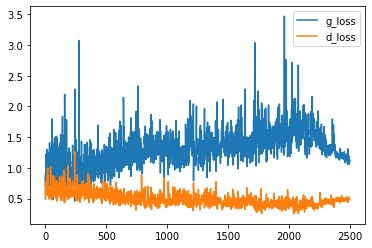

In [14]:
plt.plot(history.history["g_loss"])
plt.plot(history.history["d_loss"])
plt.legend(["g_loss", "d_loss"])

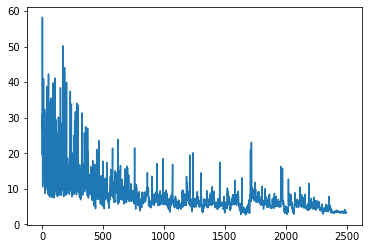

In [15]:
plt.plot(history.history["FID"])

Text(0.5, 1.0, 'rpm-power curve of true data')

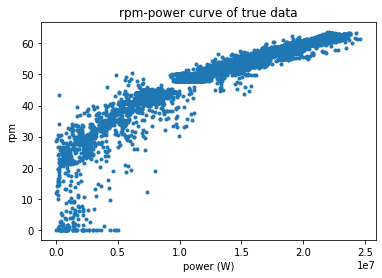

In [16]:
true_data_inv = X_scaler.inverse_transform(true_data)
plt.plot(true_data_inv[:, 0], true_data_inv[:, 1], '.')
plt.xlabel("power (W)")
plt.ylabel("rpm")
plt.title("rpm-power curve of true data")
# plt.show()

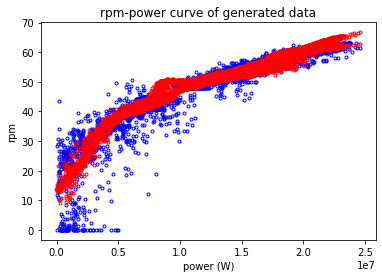

In [17]:
true_data_inv = X_scaler.inverse_transform(true_data)
plt.plot(true_data_inv[:, 0], true_data_inv[:, 1], 'b.', fillstyle='none')
plt.xlabel("power (W)")
plt.ylabel("rpm")
plt.title("rpm-power curve of true data")

fake_data_inv = X_scaler.inverse_transform(fake_data)
plt.plot(fake_data_inv[:, 0], fake_data_inv[:, 1], 'r.', fillstyle='none')
plt.xlabel("power (W)")
plt.ylabel("rpm")
plt.title("rpm-power curve of generated data")
plt.show()

In [18]:
# """
# ## Interpolating between classes with the trained generator
# """

# # We first extract the trained generator from our Conditiona GAN.
# trained_gen = cond_gan.generator

# # Choose the number of intermediate images that would be generated in
# # between the interpolation + 2 (start and last images).
# num_interpolation = 9  # @param {type:"integer"}

# # Sample noise for the interpolation.
# interpolation_noise = tf.random.normal(shape=(1, latent_dim))
# interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
# interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


# def interpolate_class(first_number, second_number):
#     # Convert the start and end labels to one-hot encoded vectors.
#     first_label = keras.utils.to_categorical([first_number], num_classes)
#     second_label = keras.utils.to_categorical([second_number], num_classes)
#     first_label = tf.cast(first_label, tf.float32)
#     second_label = tf.cast(second_label, tf.float32)

#     # Calculate the interpolation vector between the two labels.
#     percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
#     percent_second_label = tf.cast(percent_second_label, tf.float32)
#     interpolation_labels = (
#         first_label * (1 - percent_second_label) + second_label * percent_second_label
#     )

#     # Combine the noise and the labels and run inference with the generator.
#     noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
#     fake = trained_gen.predict(noise_and_labels)
#     return fake


# start_class = 1  # @param {type:"slider", min:0, max:9, step:1}
# end_class = 5  # @param {type:"slider", min:0, max:9, step:1}

# fake_images = interpolate_class(start_class, end_class)

# """
# Here, we first sample noise from a normal distribution and then we repeat that for
# `num_interpolation` times and reshape the result accordingly.
# We then distribute it uniformly for `num_interpolation`
# with the label indentities being present in some proportion.
# """

# fake_images *= 255.0
# converted_images = fake_images.astype(np.uint8)
# converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
# imageio.mimsave("animation.gif", converted_images, fps=1)
# embed.embed_file("animation.gif")

# """
# We can further improve the performance of this model with recipes like
# [WGAN-GP](https://keras.io/examples/generative/wgan_gp).
# Conditional generation is also widely used in many modern image generation architectures like
# [VQ-GANs](https://arxiv.org/abs/2012.09841), [DALL-E](https://openai.com/blog/dall-e/),
# etc.

# You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conditional-gan) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conditional-GAN).
# """